In [1]:
import sys
sys.path.append("../../")

import os

import uuid
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely import wkt

from geowrangler import dhs
from povertymapping import settings, osm, ookla, nightlights
from povertymapping.dhs import generate_dhs_cluster_level_data
from povertymapping.osm import OsmDataManager
from povertymapping.ookla import OoklaDataManager
import getpass
import pickle

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.model_selection import GroupKFold, cross_val_predict, cross_val_score, LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import shap

/home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%reload_ext autoreload
%autoreload 2

## Set up Data Access

In [3]:
# Instantiate data managers for Ookla and OSM
# This auto-caches requested data in RAM, so next fetches of the data are faster.
osm_data_manager = OsmDataManager(cache_dir=settings.ROOT_DIR/"data/data_cache")
ookla_data_manager = OoklaDataManager(cache_dir=settings.ROOT_DIR/"data/data_cache")

In [4]:
# Log-in using EOG credentials
username = os.environ.get('EOG_USER',None)
username = username if username is not None else input('Username?')
password = os.environ.get('EOG_PASSWORD',None)
password = password if password is not None else getpass.getpass('Password?') 

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username,password, save_token=True)

2023-01-26 10:35:38.181 | INFO     | povertymapping.nightlights:get_eog_access_token:47 - Saving access_token to ~/.eog_creds/eog_access_token
2023-01-26 10:35:38.184 | INFO     | povertymapping.nightlights:get_eog_access_token:55 - Adding access token to environmentt var EOG_ACCESS_TOKEN


## Load Countries From DHS data

In [5]:
# Set country-specific variables
country_config = {
    'Philippines': {
        'country_osm':'philippines',
        'ookla_year': 2019,
        'nightlights_year' : 2017,
        'country_code': 'ph',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/ph/PHHR71DT/PHHR71FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/ph/PHGE71FL/PHGE71FL.shp"
    },
    'Timor Leste': {
        'country_osm':'east-timor',
        'ookla_year': 2019,
        'nightlights_year' : 2016,
        'country_code': 'tl',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/tl/TLHR71DT/TLHR71FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/tl/TLGE71FL/TLGE71FL.shp"
    },
    'Cambodia': {
        'country_osm':'cambodia',
        'ookla_year': 2019,
        'nightlights_year' : 2014,
        'country_code': 'kh',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/kh/KHHR73DT/KHHR73FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/kh/KHGE71FL/KHGE71FL.shp"
    },
    'Myanmar': {
        'country_osm':'myanmar',
        'ookla_year': 2019,
        'nightlights_year' : 2015,
        'country_code': 'mm',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/mm/MMHR71DT/MMHR71FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/mm/MMGE71FL/MMGE71FL.shp"
    }
}

### Combine base features for all four countries
This section creates `countries_data (pd.DataFrame)` which combines DHS/Ookla/OSM/VIIRS data for all specified countries.

In [6]:
%%time

# Create list of dataframes per country, and list of all columns appearing in DHS columns
country_data_list = []
dhs_columns = ['DHSCLUST']

for country, config in country_config.items():
    print(f'Loading data for {country}')

    # Load the DHS cluster data
    dhs_household_dta_path = config['dhs_household_dta_path']
    dhs_geographic_shp_path = config['dhs_geographic_shp_path']
    country_code = config['country_code']
    dhs_gdf = generate_dhs_cluster_level_data(
        dhs_household_dta_path, 
        dhs_geographic_shp_path, 
        col_rename_config=country_code,
        convert_geoms_to_bbox=True
    ).reset_index(drop=True)

    dhs_columns = list(set(dhs_columns + list(dhs_gdf.columns)))
    

    # Generate base features for the dhs dataframe
    country_data = dhs_gdf.copy()
    country_osm = config['country_osm']
    ookla_year = config['ookla_year']
    nightlights_year = config['nightlights_year']
    
    # Add in OSM features
    country_data = osm.add_osm_poi_features(country_data, country_osm, osm_data_manager)
    country_data = osm.add_osm_road_features(country_data, country_osm, osm_data_manager)

    # Add in Ookla features
    country_data = ookla.add_ookla_features(country_data, 'fixed', ookla_year, ookla_data_manager)
    country_data = ookla.add_ookla_features(country_data, 'mobile', ookla_year, ookla_data_manager)

    # Add in the nighttime lights features
    country_data = nightlights.generate_nightlights_feature(country_data, nightlights_year) 

    country_data_list.append(country_data)

# Combine all country data into a single dataframe
countries_data = gpd.GeoDataFrame(pd.concat(country_data_list,ignore_index=True), crs=country_data_list[0].crs)


Loading data for Philippines


2023-01-26 10:36:18.617 | INFO     | povertymapping.osm:download_osm_country_data:188 - OSM Data: Cached data available for philippines at /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/philippines? True
2023-01-26 10:36:18.617 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for philippines being loaded from /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/philippines/gis_osm_pois_free_1.shp
2023-01-26 10:36:28.377 | INFO     | povertymapping.osm:download_osm_country_data:188 - OSM Data: Cached data available for philippines at /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/philippines? True
2023-01-26 10:36:28.378 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for philippines being loaded from /home/jc_tm/project_repos

Loading data for Timor Leste


2023-01-26 10:38:13.959 | INFO     | povertymapping.osm:download_osm_country_data:188 - OSM Data: Cached data available for east-timor at /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/east-timor? True
2023-01-26 10:38:13.960 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for east-timor being loaded from /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/east-timor/gis_osm_pois_free_1.shp
2023-01-26 10:38:15.567 | INFO     | povertymapping.osm:download_osm_country_data:188 - OSM Data: Cached data available for east-timor at /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/east-timor? True
2023-01-26 10:38:15.568 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for east-timor being loaded from /home/jc_tm/project_repos/unicef

Loading data for Cambodia


2023-01-26 10:38:25.520 | INFO     | povertymapping.osm:download_osm_country_data:188 - OSM Data: Cached data available for cambodia at /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/cambodia? True
2023-01-26 10:38:25.521 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for cambodia being loaded from /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/cambodia/gis_osm_pois_free_1.shp
2023-01-26 10:38:30.392 | INFO     | povertymapping.osm:download_osm_country_data:188 - OSM Data: Cached data available for cambodia at /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/cambodia? True
2023-01-26 10:38:30.393 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for cambodia being loaded from /home/jc_tm/project_repos/unicef-ai4d-poverty-

Loading data for Myanmar


2023-01-26 10:38:51.590 | INFO     | povertymapping.osm:download_osm_country_data:188 - OSM Data: Cached data available for myanmar at /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/myanmar? True
2023-01-26 10:38:51.591 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for myanmar being loaded from /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/myanmar/gis_osm_pois_free_1.shp
2023-01-26 10:38:55.289 | INFO     | povertymapping.osm:download_osm_country_data:188 - OSM Data: Cached data available for myanmar at /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/notebooks/2023-01-24-dhs-cross-country-experiments/../../data/data_cache/osm/myanmar? True
2023-01-26 10:38:55.290 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for myanmar being loaded from /home/jc_tm/project_repos/unicef-ai4d-poverty-mapping

CPU times: user 3min 19s, sys: 9.66 s, total: 3min 29s
Wall time: 3min 30s


In [7]:
dhs_columns

['ADM1SALBCO',
 'SOURCE',
 'DATUM',
 'DHSREGCO',
 'DHSYEAR',
 'ADM1FIPS',
 'ALT_DEM',
 'DHSCC',
 'LATNUM',
 'DHSCLUST',
 'Wealth Index',
 'F21',
 'ALT_GPS',
 'ADM1DHS',
 'geometry',
 'ADM1FIPSNA',
 'DHSID',
 'CCFIPS',
 'ADM1SALBNA',
 'F22',
 'F23',
 'ADM1NAME',
 'URBAN_RURA',
 'DHSREGNA',
 'LONGNUM']

### Inspect the combined target country data

In [8]:
countries_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2720 entries, 0 to 2719
Data columns (total 86 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   DHSCLUST                           2720 non-null   int64   
 1   Wealth Index                       2720 non-null   float64 
 2   DHSID                              2720 non-null   object  
 3   DHSCC                              2720 non-null   object  
 4   DHSYEAR                            2720 non-null   float64 
 5   CCFIPS                             2720 non-null   object  
 6   ADM1FIPS                           2720 non-null   object  
 7   ADM1FIPSNA                         2720 non-null   object  
 8   ADM1SALBNA                         2720 non-null   object  
 9   ADM1SALBCO                         2720 non-null   object  
 10  ADM1DHS                            2720 non-null   float64 
 11  ADM1NAME                           

In [9]:
countries_data.head()

DHSCLUST  Wealth Index           DHSID DHSCC  DHSYEAR CCFIPS ADM1FIPS  \
0         1 -31881.608696  PH201700000001    PH   2017.0   NULL     NULL   
1         2  -2855.375000  PH201700000002    PH   2017.0   NULL     NULL   
2         3 -57647.047619  PH201700000003    PH   2017.0   NULL     NULL   
3         4 -54952.666667  PH201700000004    PH   2017.0   NULL     NULL   
4         6 -80701.695652  PH201700000006    PH   2017.0   NULL     NULL   

  ADM1FIPSNA ADM1SALBNA ADM1SALBCO  ...  mobile_2019_mean_num_tests_mean  \
0       NULL       NULL       NULL  ...                              NaN   
1       NULL       NULL       NULL  ...                         0.268065   
2       NULL       NULL       NULL  ...                         0.057449   
3       NULL       NULL       NULL  ...                              NaN   
4       NULL       NULL       NULL  ...                              NaN   

  mobile_2019_mean_num_devices_mean  avg_rad_min avg_rad_max avg_rad_mean  \
0                               NaN     0.226479    0.303841     0.257759   
1                          0.156674     0.272417    6.881082     1.696226   
2                          0.034917     0.224655    0.666537     0.310964   
3                               NaN     0.213695    0.264794     0.231464   
4                               NaN     0.232324    0.285085     0.249776   

  avg_rad_std  avg_rad_median  F21  F22  F23  
0    0.020204        0.260953  NaN  NaN  NaN  
1    1.946808        0.549914  NaN  NaN  NaN  
2    0.092689        0.285651  NaN  NaN  NaN  
3    0.015785        0.227493  NaN  NaN  NaN  
4    0.013175        0.245621  NaN  NaN  NaN  

[5 rows x 86 columns]

In [10]:
# Check if DHS CC can be used as a country grouping column
countries_data['DHSCC'].value_counts()

PH    1213
KH     611
TL     455
MM     441
Name: DHSCC, dtype: int64

In [11]:
# Explore as a map with first 30 columns in tooltip
countries_data.iloc[:, :30].explore()

## Data Preparation

### Split into labels and features

In [120]:
# Set parameters
label_col = 'Wealth Index'
normalize_labels = 'single-country' # False, 'cross-country' or 'single_country'
# normalize_labels = 'cross-country'

In [121]:
# Split train/test data into features and labels

# For labels, we just select the target label column
labels = countries_data[[label_col]]

# For features, drop all columns from the input dhs files
# If you need the cluster data, refer to country_data / country_test
features = countries_data.drop(dhs_columns, axis=1)

features.shape, labels.shape

((2720, 61), (2720, 1))

### Normalize labels
> TODO: normalize per country

In [122]:
if normalize_labels is not False:
    scaler = MinMaxScaler(feature_range=(0,1))
    if normalize_labels == 'cross-country':      
        labels[labels.columns] = scaler.fit_transform(labels)
    elif normalize_labels == 'single-country':
        labels_temp = labels.copy()
        labels_temp['group_col'] = countries_data['DHSCC']
        labels_temp[f'{label_col}_scaled'] = labels_temp.groupby('group_col', group_keys=False)[label_col].apply(lambda x: (x-min(x))/(max(x)-min(x)))
        labels[label_col] = labels_temp[f'{label_col}_scaled']
display(labels)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wealth Index
0         0.374681
1         0.446489
2         0.310939
3         0.317605
4         0.253904
...            ...
2715      0.593194
2716      0.328432
2717      0.485159
2718      0.398905
2719      0.791023

[2720 rows x 1 columns]

### Clean Features

In [123]:
# Clean features
# For now, just impute nans with 0
# TODO: Implement other cleaning steps
features = features.fillna(0)

### Base Features List

The features can be subdivided by the source dataset

#### OSM
- `<poi type>_count`: number of points of interest (POI) of a specified type in that area
    - ex. atm_count: number of atms in cluster
    - poi_count: number of all POIs *of all types* in cluster 
- `<poi_type>_nearest`: distance of nearest POI of the specified type
    - ex. atm_nearest: distance of nearest ATM from that cluster
- OSM POI types included: `atm`, `bank`, `bus_stations`, `cafe`, `charging_station`, `courthouse`, `dentist` (clinic), `fast_food`, `fire_station`, `food_court`, `fuel` (gas station), `hospital`, `library`, `marketplace`, `pharmacy`, `police`, `post_box`, `post_office`, `restaurant`, `social_facility`, `supermarket`, `townhall`, `road`

#### Ookla 
The network metrics features follow the following name convention:

> `<type>_<year>_<yearly aggregate>_<network variable>_<cluster aggregate>`

- type: kind of network connection measured
    - fixed: connection from fixed sources (landline, fiber, etc.)
    - mobile: connection from mobile devices
- year: Year of source data
- yearly aggregate: How data was aggregated into yearly data
    - Note: Ookla provides data per quarter, so a yearly mean takes the average across 4 quarters
    - For this model, we only aggregate by yearly mean
- network variable: network characteristic described
    - avg_d_kbps: average download speed in kbps
    - avg_u_kbps: average upload speed in kbps
    - avg_lat_ms: average latency in ms
    - num_devices: number of devices measured
- cluster aggregate: how the data was aggregated per cluster aggregate
    - Types: min, mean, max, median, std.
        - For this model: only mean is used 
    - This is calculated using area zonal stats, which weighs the average by the intersection of the Ookla tile with the cluster geometry.
    
    
Ex. `fixed_2019_mean_avg_d_kbps_median` takes the cluster median of 2019 yearly average download speed.


#### Nightlights (VIIRS)
All nightlights features are taken as the zonal aggregate of the raster data per cluster

- ex. `avg_rad_mean`: cluster mean of the average radiance 
- aggregations used: min, mean, max, median


In [124]:
features.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2720 entries, 0 to 2719
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   poi_count                          2720 non-null   float64
 1   atm_count                          2720 non-null   float64
 2   atm_nearest                        2720 non-null   float64
 3   bank_count                         2720 non-null   float64
 4   bank_nearest                       2720 non-null   float64
 5   bus_station_count                  2720 non-null   float64
 6   bus_station_nearest                2720 non-null   float64
 7   cafe_count                         2720 non-null   float64
 8   cafe_nearest                       2720 non-null   float64
 9   charging_station_count             2720 non-null   float64
 10  charging_station_nearest           2720 non-null   float64
 11  courthouse_count                   2720 non-null

## Model Training

In [125]:
# Set parameters
groupkfold_col = 'DHSCC'
# cv_num_splits = 5
# cv_num_repeats = 5
train_test_seed = 42
test_size = 0.2

### Create train/test cross-validation indices

In [126]:
# train_features, test_features, train_labels, test_labels = train_test_split(
#     features, labels, test_size=test_size, random_state=train_test_seed
# )

# Cross validation
print(f"Performing GroupKFold CV with groups based on DHSCC...")
groups = countries_data[groupkfold_col].values
cv = GroupKFold(n_splits = len(set(groups)))

print(cv.split(features, groups=groups))
print(f'Number of splits based on DHSCC unique values: {cv.get_n_splits()}')


Performing GroupKFold CV with groups based on DHSCC...
<generator object _BaseKFold.split at 0x7fbc3dbee900>
Number of splits based on DHSCC unique values: 4


### Instantiate model
For now, we will train a simple random forest model

In [127]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=train_test_seed, verbose=0)
model

RandomForestRegressor(random_state=42)

### Evaluate model training using cross-validation
We evalute the model's generalizability when training over different train/test splits

Ideally for R^2

- We want a high mean: This means that we achieve a high model performance over the different train/test splits
- We want a low standard deviation (std): This means that the model performance is stable over multiple training repetitions

In [128]:
R_cv = cross_val_score(model, features.values, labels.values.ravel(), cv=cv, groups=groups)
print("Cross validation scores are: ", sorted(R_cv))
cv_mean = round(np.array(R_cv).mean(), 2)
cv_std = round(np.array(R_cv).std(), 2)
print(f"Cross validation R^2 mean: {cv_mean}")
print(f"Cross validation R^2 std: {cv_std}")

Cross validation scores are:  [0.24662448024127204, 0.3441301499695383, 0.44905656579924735, 0.5854026978650345]
Cross validation R^2 mean: 0.41
Cross validation R^2 std: 0.13


The following code cell trains a model for each combination of (3 train countries, 1 test country). Functionally, it gives us the same output from `cross_val_score` but gives us more information about the train/test split.

Split# 1
Train countries (num samples): {'KH', 'MM', 'TL'} (1507)
Test countries (num samples): {'PH'} (1213)
Split r^2: 0.24662448024127204 



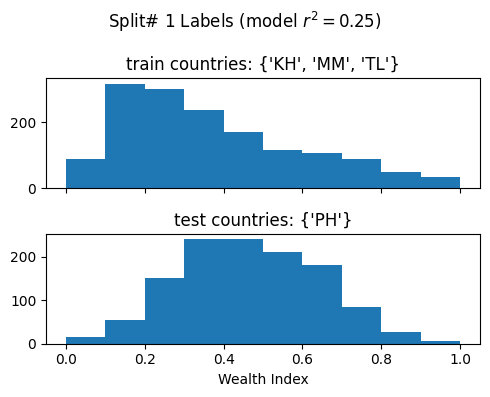

Split# 2
Train countries (num samples): {'PH', 'MM', 'TL'} (2109)
Test countries (num samples): {'KH'} (611)
Split r^2: 0.5854026978650345 



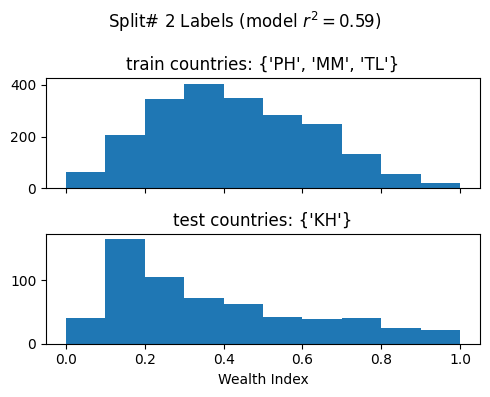

Split# 3
Train countries (num samples): {'PH', 'MM', 'KH'} (2265)
Test countries (num samples): {'TL'} (455)
Split r^2: 0.3441301499695383 



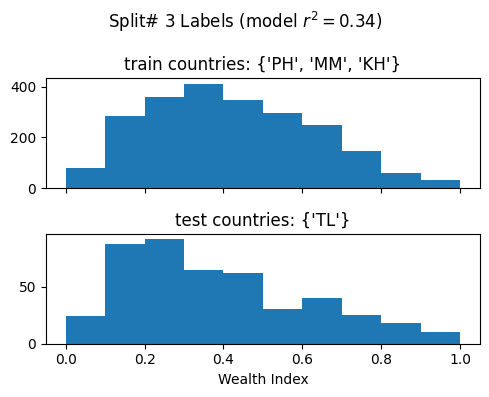

Split# 4
Train countries (num samples): {'PH', 'KH', 'TL'} (2279)
Test countries (num samples): {'MM'} (441)
Split r^2: 0.44905656579924735 



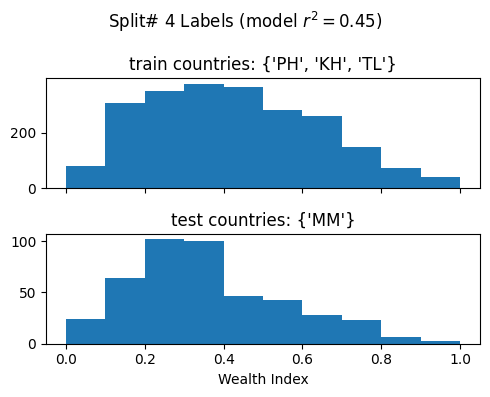

Mean split r^2  (std): 0.41 (0.13)


In [129]:
split_r2_list = []

for i, (train, test) in enumerate(cv.split(features, labels,groups=groups)):
    print(f'Split# {i+1}')

    # Print info about current split
    train_labels = set(groups[train])
    test_labels = set(groups[test])
    print(f'Train countries (num samples): {train_labels} ({len(train)})')
    print(f'Test countries (num samples): {test_labels} ({len(test)})')

    # Split data into train/test
    X_train = features.values[train]
    X_test = features.values[test]
    y_train = labels.values.ravel()[train]
    y_test = labels.values.ravel()[test]

    # print('Input shapes (X_train, X_test, y_train, y_test): ',np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

    # Train model and get r2
    model.fit(X_train, y_train)
    split_r2 = r2_score(y_test, model.predict(X_test))
    split_r2_list.append(split_r2)
    print(f'Split r^2: {split_r2} \n')

    # Plot histogram of labels
    fig, ax = plt.subplots(2,1, sharex=True, figsize=(5,4))
    ax[0].hist(y_train)
    ax[0].set_title(f'train countries: {train_labels}')
    ax[1].hist(y_test)
    ax[1].set_title(f'test countries: {test_labels}')
    ax[1].set_xlabel('Wealth Index')
    fig.suptitle(f'Split# {i+1} Labels (model $r^2 = {round(split_r2,2)}$)')
    plt.tight_layout()
    plt.show()

split_r2_mean = round(np.array(split_r2_list).mean(), 2)
split_r2_std = round(np.array(split_r2_list).std(), 2)
print(f'Mean split r^2  (std): {split_r2_mean} ({split_r2_std})')



## Exploratory Data Analysis

### Per-country wealth index

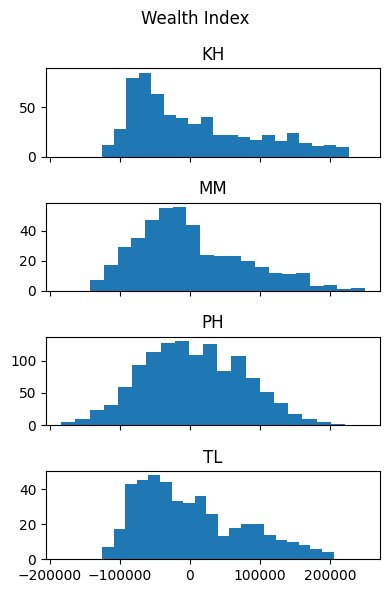

In [130]:
countries_data['Wealth Index'].hist(by=countries_data['DHSCC'], figsize = (4,6),layout=(4,1),  sharex=True, xrot=0, bins=20)
plt.suptitle('Wealth Index')
plt.tight_layout()
plt.show()

## Per-country features

In [131]:
features.columns

Index(['poi_count', 'atm_count', 'atm_nearest', 'bank_count', 'bank_nearest',
       'bus_station_count', 'bus_station_nearest', 'cafe_count',
       'cafe_nearest', 'charging_station_count', 'charging_station_nearest',
       'courthouse_count', 'courthouse_nearest', 'dentist_count',
       'dentist_nearest', 'fast_food_count', 'fast_food_nearest',
       'fire_station_count', 'fire_station_nearest', 'food_court_count',
       'food_court_nearest', 'fuel_count', 'fuel_nearest', 'hospital_count',
       'hospital_nearest', 'library_count', 'library_nearest',
       'marketplace_count', 'marketplace_nearest', 'pharmacy_count',
       'pharmacy_nearest', 'police_count', 'police_nearest', 'post_box_count',
       'post_box_nearest', 'post_office_count', 'post_office_nearest',
       'restaurant_count', 'restaurant_nearest', 'social_facility_count',
       'social_facility_nearest', 'supermarket_count', 'supermarket_nearest',
       'townhall_count', 'townhall_nearest', 'road_count',
     

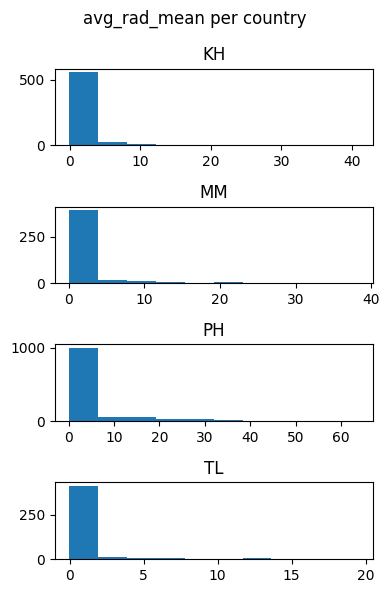

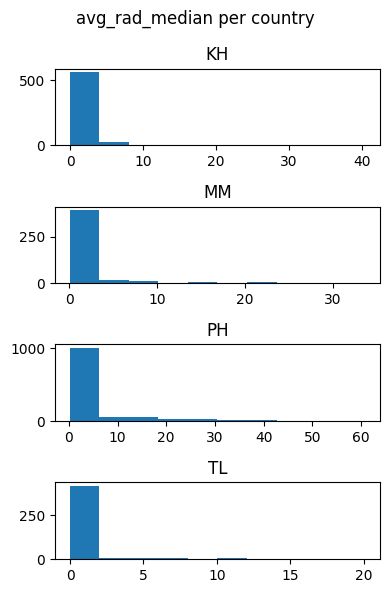

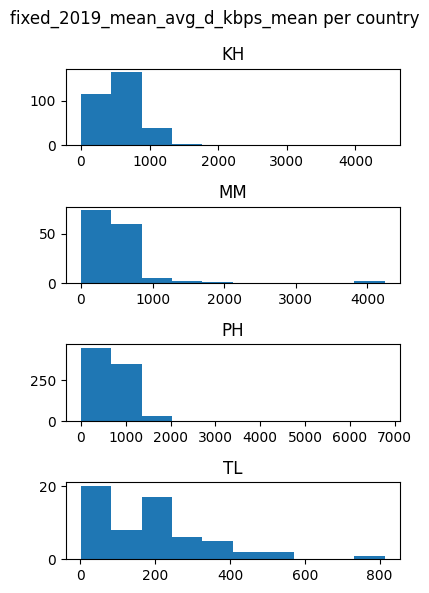

In [132]:
features_list = ['avg_rad_mean', 'avg_rad_median', 'fixed_2019_mean_avg_d_kbps_mean']

for feature in features_list:
    countries_data[feature].hist(by=countries_data['DHSCC'], figsize = (4,6),layout=(4,1), xrot=0)
    plt.suptitle(f'{feature} per country')
    plt.tight_layout()
    plt.show()